In [1]:
# import multiprocessing as mp
# print(mp.get_start_method())
# mp.set_start_method('spawn')
# print(mp.get_start_method())

import os
import sys
import pandas as pd
from matplotlib import pyplot as plt

# add tsa to path
SCRIPT_DIR = os.path.abspath("../tsa")
sys.path.append(os.path.dirname(SCRIPT_DIR))

from tsa.preprocessing import get_sample_info, tpm_normalization, merge_replicates
from tsa.gpr import gpr
from tsa.gene_selection import score_normalization, plot_scores, best_n_genes
from tsa.clustering import cluster_genes
# from tsa.alignment import time_series_alignment
from tsa.utils import inference_timeseries, all_numeric

plt.rcParams['figure.figsize'] = [8, 6]

# Input files

In [2]:
tpm_file = "../data/GRCz11-TPM.tsv"
tpms = pd.read_csv(tpm_file, sep="\t", index_col=0)

template_samples_file = "../data/white_mpf_samples.tsv"
query_samples_file = "../data/levin_mpf_samples.tsv"
# query_samples_file = "data/white_mpf_samples.tsv"  # control
# query_samples_file = "data/marletaz_mpf_samples.tsv"

# currently ran for 
# 18906 genes with min(TPM) > 5 and median(TPM) > 0 (2 ConvergenceWarnings: gene 4096 and 4817)
# with 171 points (10 per original timepoint)
new_gpr = False
gpr_inference_file = "../data/white_mpf_gpr.tsv"
gpr_scores_file = "../data/white_mpf_score.tsv"

# showcase_gene = "ENSDARG00000000212"
showcase_gene = "ENSDARG00000000018"

In [3]:
# tpm_file = "data/XT9.1-TPM.tsv"
# tpms = pd.read_csv(tpm_file, sep="\t", index_col=0)

# template_samples_file = "data/owensA1_mpf_samples.tsv"
# # query_samples_file = "data/owensA1_mpf_samples.tsv"  # control
# # query_samples_file = "data/owensA2_mpf_samples.tsv"
# # query_samples_file = "data/owensB1_mpf_samples.tsv"
# query_samples_file = "data/tanA_mpf_samples.tsv"
# # query_samples_file = "data/tanB_mpf_samples.tsv"

# new_gpr = False
# gpr_inference_file = "data/owensA1_mpf_gpr.tsv"
# gpr_scores_file = "data/owensA1_mpf_score.tsv"

# showcase_gene = "ENSXETG00000000002"

# Infer expression over time for template genes

In [4]:
# preprocessing
template_samples = pd.read_csv(template_samples_file, sep="\t", index_col=0)
template_sample_order, template_time2samples = get_sample_info(template_samples)

template_tpms = tpm_normalization(tpms, template_sample_order, min_value=5, min_median_value=0, verbose=True)

template_tpms.head(3)

11063 genes with max below 5 TPM (34%)
2243 genes with median below or equal to 0 TPM (10%)
18906 genes, 90 samples left after filtering


,1-cell-1,1-cell-2,1-cell-3,1-cell-4,1-cell-5,2-cell-1,2-cell-2,2-cell-3,2-cell-4,2-cell-5,...,Day-4-1,Day-4-2,Day-4-3,Day-4-4,Day-4-5,Day-5-1,Day-5-2,Day-5-3,Day-5-4,Day-5-5
gene,,,,,,,,,,,,,,,,,,,,,
ENSDARG00000000001,3.500623,3.193223,2.993834,3.134451,2.930888,3.063963,3.358324,3.177872,3.182704,3.292535,...,1.268145,0.875185,1.372952,0.953276,1.219284,1.252780,1.293310,1.701401,1.087258,0.985310
ENSDARG00000000002,1.798363,1.850706,1.549031,1.842664,1.618451,2.919417,2.731890,2.547173,2.881035,2.495728,...,2.909071,3.259391,3.423040,3.203155,2.933308,3.054464,3.049627,3.124625,2.925538,3.317229
ENSDARG00000000018,3.825139,3.883515,3.443959,3.688393,3.947403,4.004615,4.161532,4.129312,4.164329,3.913867,...,4.537668,4.042059,4.059302,4.259864,4.103876,4.459250,4.421675,4.362885,4.252356,4.371778


In [5]:
# help(gpr)

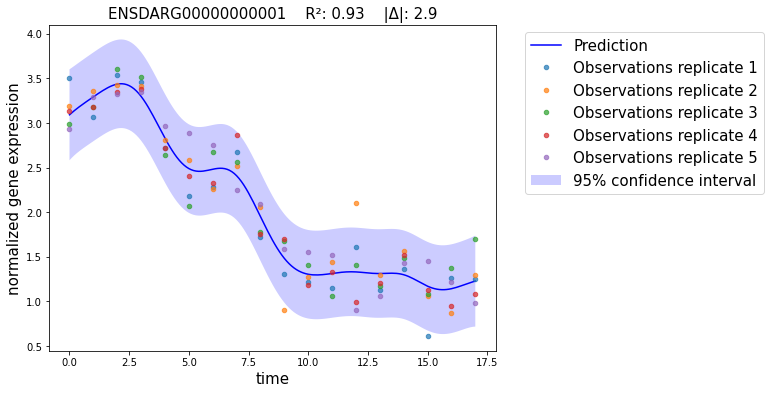

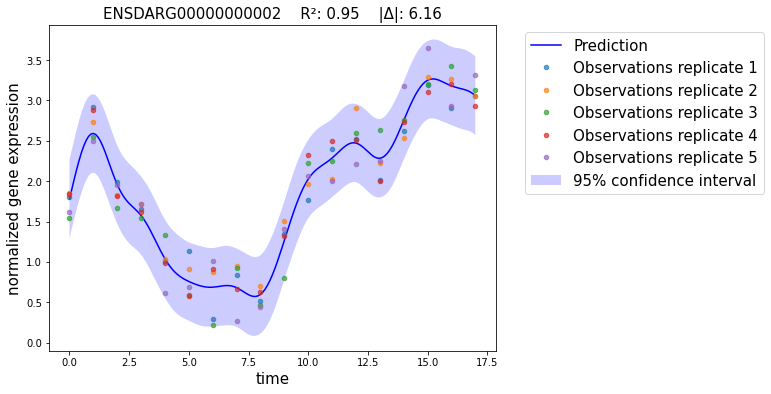

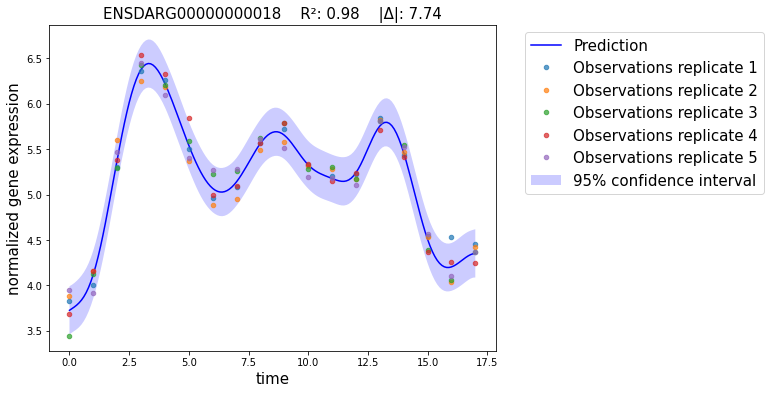

In [6]:
# # linear space
# extended_timepoints = list(np.round(np.linspace(min(time2samples), max(time2samples), 10), 2))

# infer n timepoints for each original timepoint 
timepoints_per_sample = 10
extended_timepoints = inference_timeseries(list(template_time2samples), timepoints_per_sample)

# run 3x with pictures
tmp, _ = gpr(template_time2samples, template_tpms, extended_timepoints, plot=True, verbose=False, run_n=3)

if new_gpr:
    # run with all genes
    template_tpms_inf, gpr_scores = gpr(template_time2samples, template_tpms, extended_timepoints, plot=False, verbose=True, run_n=None)
    
    template_tpms_inf.to_csv(gpr_inference_file, sep="\t")
    gpr_scores.to_csv(gpr_scores_file, sep="\t")
else:
    template_tpms_inf = pd.read_csv(gpr_inference_file, sep="\t", index_col=0)
    gpr_scores = pd.read_csv(gpr_scores_file, sep="\t", index_col=0)


In [7]:
# when loading a gpr inference table, make sure the rows and columns match the settings
if new_gpr is False:
    gene = tmp.index[0]
    if tmp.index[0] != template_tpms_inf.index[0]:
        raise ValueError("`template_tpms` gene order has changed since creating the template_tpms_inf table")
    if tmp.columns.equals(template_tpms_inf.columns):
        raise ValueError("`extended_timepoints` has changed since creating the template_tpms_inf table")
    print("all good!")

all good!


### Filter template genes by GPR model accuracy (R-squared), expression variability, or both.

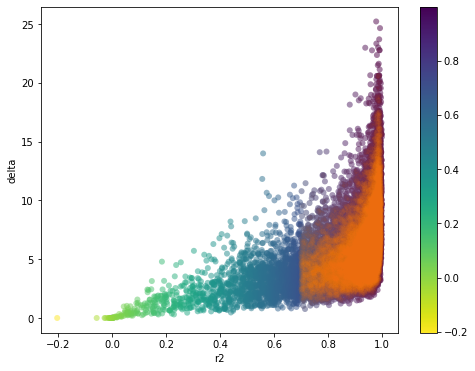

In [8]:
# remove genes that weren't modelled accurately
weight_expr=0
min_r2 = 0.7
weight_r2=1

gpr_scores.dropna(inplace=True)
gpr_normscores = score_normalization(gpr_scores, weight_expr, weight_r2)
top_template_genes = gpr_normscores[gpr_normscores.r2 >= min_r2].index.to_list()
plot_scores(gpr_normscores, highlight_top_n=len(top_template_genes))

# n = 12_000
# top_template_genes = best_n_genes(gpr_normscores, n)
# gpr_normscores = score_normalization(gpr_scores, weight_expr=1, weight_r2=3)
# plot_scores(gpr_normscores, highlight_top_n=n)

# Gene selection

In [9]:
# preprocessing
query_samples = pd.read_csv(query_samples_file, sep="\t", index_col=0)
sample_order, time2samples = get_sample_info(query_samples)

target_distribution = template_tpms[template_tpms.columns[0]].to_list()
query_tpms = tpm_normalization(tpms, sample_order, min_value=5, min_median_value=0, qnorm_target_dist=target_distribution)

# TODO: other methods, such as GPR?
query_tpms = merge_replicates(query_tpms, time2samples, how="mean")

if all_numeric(time2samples):
    # convert time to numeric
    samples2time = query_samples.to_dict()["time"]
    query_tpms = query_tpms.rename(columns=samples2time)

query_tpms.head(3)

14459 genes with max below 5 TPM (44%)
10529 genes with median below or equal to 0 TPM (59%)
7224 genes, 106 samples left after filtering


,40.0,80.0,120.0,160.0,200.0,240.0,280.0,320.0,360.0,400.0,...,3880.0,3920.0,3960.0,4000.0,4040.0,4080.0,4120.0,4160.0,4200.0,4240.0
gene,,,,,,,,,,,,,,,,,,,,,
ENSDARG00000000018,2.357917,1.313048,2.093334,2.216387,2.352216,2.140434,1.989515,1.496524,2.157660,2.323968,...,1.859458,2.111331,1.770380,2.648192,2.008083,1.942561,1.946196,1.565307,2.343962,1.827743
ENSDARG00000000019,2.385993,1.313048,1.867834,1.969603,2.404031,1.557214,2.560186,2.534587,1.399566,2.185818,...,2.055717,1.377387,0.799732,1.588488,1.643117,1.403235,0.799732,1.708216,2.110440,1.827743
ENSDARG00000000068,2.394796,1.313048,2.529162,0.904687,2.427654,2.415728,2.150868,1.496524,1.399566,1.301904,...,1.304464,0.799732,0.799732,1.588488,0.799732,1.878888,0.799732,1.976121,1.146203,1.827743


In [10]:
# overlap of query genes & top template genes
query_genes = query_tpms.index
starting_genes = set(top_template_genes).intersection(query_genes)

print(len(starting_genes), "overlapping genes")

# template_gene_clusters = cluster_genes(template_tpms_inf, starting_genes, n_clusters=None)

6886 overlapping genes


# TSA

In [11]:
# import numpy as np
# from tsa.alignment import get_cost_matrix, best_alignment_graph, _avg_alignments, plot_alignment, plot_gene
# from tsa.utils import list2floats, all_numeric
# import random

### with replacement

In [12]:
# # pool fork: duplicates current state, including all packages and objects
# # pool spawn: clean env, but slower
# mp.Pool(maxtasksperchild=1000)

# # shared memory objects: manager (can be anything), array and value (np.memmap?)

# # modin/ray can be applied on top of pandas

# tasks = [pool.apply_async(func, args) for args in mylist]
# res = [t.get() for t in tasks]

# pool.join()
# pool.close()

In [24]:
# from sklearn.cluster import KMeans
# import warnings

# n_clusters = 8
# genes = list(starting_genes)
# df = template_tpms_inf.loc[genes]

# kmeans = KMeans(init="k-means++", n_clusters=n_clusters, n_init=4)
# kmeans.fit(df)
# k = kmeans.predict(df)

# gene_cluster_df = pd.DataFrame({"gene": genes, "cluster": k}).set_index("gene")

# with warnings.catch_warnings():
#     warnings.simplefilter("ignore")
#     for c in range(n_clusters):
#         clust = df[gene_cluster_df.cluster == c]
#         clust.mean().plot(label=f"cluster {c} ({len(test)} genes)")
# plt.title("cluster patterns", fontsize=15)
# plt.ylabel("normalized expression", fontsize=18)
# plt.xlabel("time", fontsize=15)
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=15)
# plt.show()

In [14]:
# def avg_alignment(template_tpms_inf, query_tpms, gene_cluster_df, tries=10, frac=None, n_clust=None, n_total=None, metric='correlation', method="mean", showcase_gene=None, plot=True, verbose=True, return_std=False):
#     """
#     frac: fraction of genes to use (per cluster)
#     n_clust: number of genes to use per cluster
#     n_total: total number of genes to use in the alignment
#     """
#     # run tries in parallel
#     p =  max(1, min(int(os.cpu_count()*0.9), os.cpu_count()-2, tries))
#     pool = mp.Pool(processes=p)  # , maxtasksperchild=1000)
    
#     clusters = list(set(gene_cluster_df.cluster))
#     n_clusters = len(clusters)
#     c_avg = None
#     if n_total:
#         c_avg = int(n_total/n_clusters)    
    
#     jobs = [
#         pool.apply_async(
#             func=align_subset, 
#             args=(template_tpms_inf, query_tpms, gene_cluster_df, frac, n_clust, c_avg, metric, random.randint(0, 999))
#         ) for _ in range(tries)
#     ]
#     # paths = np.asarray([j.get() for j in jobs])
#     paths = []
#     for try_n, j in enumerate(jobs):
#         if verbose:
#             print(f"{int(100*try_n/tries)}%", end="\r")
#         paths.append(j.get())
#     paths = np.asarray(paths)
#     pool.close()
#     pool.join()

#     # combine tries
#     inference_time = list2floats(template_tpms_inf.columns)
#     query_time = list2floats(query_tpms.columns)
#     is_time_numeric = all_numeric(inference_time) and all_numeric(query_time)
    
#     print("mean")
#     avg_path, std_path = combine_alignments(paths, inference_time, is_time_numeric, method="mean")

#     # re-create a dataframe with required metadata
#     r = random.randint(0, 999)
#     if frac is not None:
#         # fraction of genes per cluster
#         genes = gene_cluster_df.groupby("cluster").sample(frac=frac, random_state=r).index.to_list()
#     elif n_clust is not None:
#         # fixed number of genes per cluster
#         genes = gene_cluster_df.groupby("cluster").sample(n=n_clust, replace=True, random_state=r).index.to_list()
#     elif c_avg is not None:
#         # fixed number of genes divided over the number of clusters
#         genes = gene_cluster_df.groupby("cluster").sample(n=c_avg, replace=True, random_state=r).index.to_list()
#     else:
#         raise ValueError("need n, frac or c_avg")
#     t = template_tpms_inf.loc[genes]
#     q = query_tpms.loc[genes]
#     cost_matrix = get_cost_matrix(t, q, metric)
#     cm = pd.DataFrame(cost_matrix, index=q.columns, columns=t.columns)

#     n_genes = len(query_tpms)
#     n_genes_used = len(q)
#     print(f"{n_clusters} clusters, {n_genes_used} total genes used.")
#     plot_alignment(cm, avg_path, std_path)

#     print("median")
#     avg_path, std_path = combine_alignments(paths, inference_time, is_time_numeric, method="median")

#     # re-create a dataframe with required metadata
#     r = 1
#     if frac is not None:
#         # fraction of genes per cluster
#         genes = gene_cluster_df.groupby("cluster").sample(frac=frac, random_state=r).index.to_list()
#     elif n_clust is not None:
#         # fixed number of genes per cluster
#         genes = gene_cluster_df.groupby("cluster").sample(n=n_clust, replace=True, random_state=r).index.to_list()
#     elif c_avg is not None:
#         # fixed number of genes divided over the number of clusters
#         genes = gene_cluster_df.groupby("cluster").sample(n=c_avg, replace=True, random_state=r).index.to_list()
#     else:
#         raise ValueError("need n, frac or c_avg")
#     t = template_tpms_inf.loc[genes]
#     q = query_tpms.loc[genes]
#     cost_matrix = get_cost_matrix(t, q, metric)
#     cm = pd.DataFrame(cost_matrix, index=q.columns, columns=t.columns)

#     n_genes = len(query_tpms)
#     n_genes_used = len(q)
#     print(f"{n_clusters} clusters, {n_genes_used} total genes used.")
#     plot_alignment(cm, avg_path, std_path)

In [15]:
# def best_alignment_graph(cost_matrix: np.array) -> tuple:
#     len_query, len_template = cost_matrix.shape
#     G = nx.DiGraph()

#     # add start edges
#     all_edges = [("start", (0, i), cost_matrix[0, i]) for i in range(len_template)]

#     # nodes are named as 2d tuples of coordinates ((q)uery point, (t)emplate point)
#     # each node connects to the next number of q, and the same or higher number of t
#     for q in range(len_query-1):
#         for t in range(len_template):
#             node_i = (q, t)
#             for t2 in range(t, len_template):
#                 node_j = (q+1, t2)
#                 all_edges.append((node_i, node_j, cost_matrix[node_j]))

#     # add final edges
#     all_edges.extend([((len_query-1, i), "end", 0) for i in range(len_template)])

#     # now load them in networkx
#     G.add_weighted_edges_from(all_edges)

#     best_path = nx.shortest_path(G, source="start", target="end", weight='weight')[1:-1]
#     best_path_template, best_path_query = zip(*best_path)
#     best_score = cost_matrix[best_path_template, best_path_query].sum()
#     best_path = best_path_query

#     return best_path, best_score

In [16]:
# import inspect
# import numpy as np
# import pandas as pd
# from scipy.spatial.distance import cdist
# import networkx as nx
# from matplotlib import pyplot as plt
# import random
# import sklearn

# from tsa.clustering import top_cluster_genes
# from tsa.utils import all_numeric, list2floats
# from typing import Union, List

# def combine_alignments(paths: List[list], inference_time: list = None, is_time_numeric: bool = False, force_chonological: bool = True, method: Union[str,int] = "mean"):
#     """
#     Combine {paths}, a list of integer lists, into a single list using the specified {method}.
#     If {method} is an integer, use that parcentile.
#     If {force_chonological} is True, the combined path will be made chronological.
    
#     This function also returns the standard deviation as a (2,n) numpy array.
#     If time is numeric, the std will be returned in inferred time, instead of column indeces.
#     """
#     # combine paths
#     if method=="mean":
#         path = [int(i) for i in np.mean(paths, axis=0)]
#     elif method=="median":
#         path = [int(i) for i in np.median(paths, axis=0)]
#     elif isinstance(method, int):
#         path = [int(i) for i in np.percentile(paths, q=int(method), axis=0)]
#     else:
#         raise ValueError("`method` must be 'mean', 'median' or a integer precentile")
        
#     # standard deviation from the combined path
#     std_path = paths.std(axis=0).tolist()
#     # if time is numeric, we convert the std to inferred time
#     if is_time_numeric:
#         if inference_time is None:
#             raise ValueError("`inference_time` is required when time is numeric")
#         end = len(inference_time)-1
#         for n, p in enumerate(path):
#             inf_time = inference_time[p]
#             std_time_min = abs(inference_time[max(0,   p - int(std_path[n]))]-inf_time)
#             std_time_max = abs(inference_time[min(end, p + int(std_path[n]))]-inf_time)
#             std_path[n] = [std_time_min, std_time_max]
#     std_path = np.array(std_path).T
    
#     if force_chonological:
#         # if an average timepoint is earlier than the previous timepoint, increase it to match
#         for n in range(1, len(path)):
#             if path[n-1] > path[n]:
#                 path[n] = path[n-1]
                
#     return path, std_path


# def _parse_sampling(frac=None, n_clust=None, n_total=None):
#     """raise an error if not exactly one of the variables is specified"""
#     vals = sum([1 for _ in [frac, n_clust, n_total] if _ is not None])
#     if vals != 1:
#         raise ValueError("need either frac, n_clust or n_total")

        
# def _sample_genes(gene_cluster_df, frac=None, n=None, r=None):    
#     # frac != None: fraction of genes per cluster
#     # n != None: fixed number of genes per cluster/divided over the number of clusters
#     # uses replacement if n was specified
#     genes = gene_cluster_df.groupby("cluster").sample(n=n, frac=frac, replace=bool(n), random_state=r).index.to_list() 
#     return genes


# def subset_alignment(template_tpms_inf, query_tpms, gene_cluster_df, frac=None, n=None, metric='correlation', r=None):
#     """
#     Apply a local time series alignment of {query_tpms} to {template_tpms_inf}, using a subset of genes.
#     The subset is drawn from {gene_cluster_df}, where a number of genes is used from each cluster.
#     This can be a {frac}tion of genes, or an exact {n}umber.
    
#     When using this function in parallel, a {r}andom number is required.
    
#     Returns an alignment path
#     """
#     genes = _sample_genes(gene_cluster_df, frac, n, r)
#     del gene_cluster_df
#     del frac
#     del n
#     del r

#     t = template_tpms_inf.loc[genes]
#     del template_tpms_inf
#     q = query_tpms.loc[genes]
#     del query_tpms
    
#     cost_matrix = get_cost_matrix(t, q, metric)
#     path = best_alignment_graph(cost_matrix)[0]
#     del cost_matrix
    
#     return path


# def multi_alignment(
#     template_tpms_inf, query_tpms, gene_cluster_df, 
#     tries=10, frac=None, n_clust=None, n_total=None, 
#     metric="correlation", method="mean", ncpu=4,
#     showcase_gene=None, plot=True, verbose=True, return_std=False
# ):
#     """
#     Run a number of subset_alignments (in parallel), using combine_alignments on the results.
    
#     tries: number of times the alignment is performed.
#     frac: fraction of genes to use per cluster
#     n_clust: number of genes to use per cluster
#     n_total: total number of genes to use (rounding down if required)
#     """
#     _parse_sampling(frac, n_clust, n_total)
    
#     # run tries in parallel
#     p =  max(1, min(ncpu, os.cpu_count()-1, tries))
#     pool = mp.Pool(processes=p)  # , maxtasksperchild=1000)
    
#     clusters = list(set(gene_cluster_df.cluster))
#     n_clusters = len(clusters)
#     if n_total:
#         # fixed number of genes divided over the number of clusters
#         n_clust = int(n_total/n_clusters)    
    
#     jobs = [
#         pool.apply_async(
#             func=subset_alignment, 
#             args=(template_tpms_inf, query_tpms, gene_cluster_df, frac, n_clust, metric, random.randint(0, 999))
#         ) for _ in range(tries)
#     ]
#     # paths = np.asarray([j.get() for j in jobs])
#     paths = []
#     for try_n, j in enumerate(jobs):
#         if verbose:
#             print(f"{int(100*try_n/tries)}%", end="\r")
#         paths.append(j.get())
#     paths = np.asarray(paths)
#     pool.close()
#     pool.join()

#     # combine tries
#     inference_time = list2floats(template_tpms_inf.columns)
#     query_time = list2floats(query_tpms.columns)
#     is_time_numeric = all_numeric(inference_time) and all_numeric(query_time)
#     path, std_path = combine_alignments(paths, inference_time, is_time_numeric, method=method)
    
#     if plot:
#         if verbose:
#             start_msg = f"TSA of {tries} alignments"
#             clust_msg = f" with {n_clusters} clusters" if n_clusters > 1 else ""
#             gene_no = int(len(query_tpms)*frac) if frac is not None else n_clusters*n_clust
#             print(f"\t{start_msg}{clust_msg}, {gene_no} genes.")
#         plot_alignment(template_time, query_time, path, std_path, is_time_numeric)

#     if return_std:
#         return path, std_path
#     return path


# def plot_alignment(template_time, query_time, path, std_path=None, is_time_numeric=False):
#     if is_time_numeric:
#         q = query_time
#         t = [template_time[i] for i in path]
        
#         # add diagonal
#         start = min(t[0], q[0])
#         end = max(t[-1], q[-1])
#         plt.plot([start, end], [start, end], 'orange', alpha=0.2, ls='--')
        
#         plt.ylim(t[0], t[-1])
#         plt.xlim(q[0], q[-1])
#     else:
#         q = list(range(len(path)))
#         t = path

#         plt.ylim(0, len(template_time)-1)
#         plt.xlim(0, len(query_time)-1)
    
#     plt.plot(q, t, alpha=0.5)
#     plt.scatter(q, t, s=10, color="black")
#     if std_path is not None:
#         plt.errorbar(q, t, color="grey", yerr=std_path, alpha=0.4, fmt='none')
    
#     plt.title("local alignment", fontsize=15)
#     plt.ylabel("template time", fontsize=18)
#     plt.xlabel("query time", fontsize=15)
#     plt.show()


	TSA of 2 alignments with 7 clusters, 350 genes.


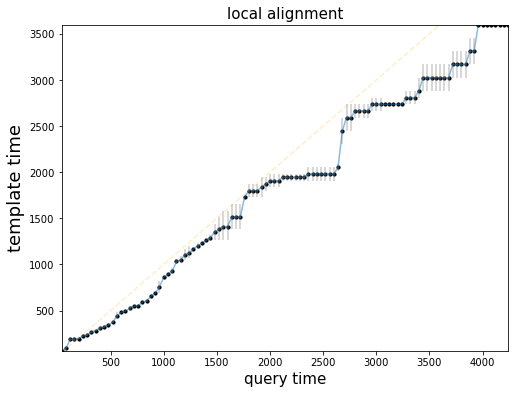

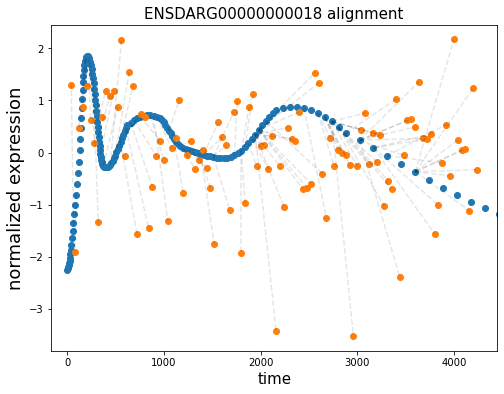

[12, 15, 31, 31, 32, 35, 37, 41, 44, 49, 52, 56, 61, 67, 70, 71, 73, 75, 75, 78, 79, 81, 82, 84, 87, 88, 89, 94, 95, 98, 99, 101, 102, 103, 104, 105, 107, 108, 109, 109, 112, 112, 112, 118, 120, 120, 120, 121, 122, 123, 123, 123, 124, 124, 124, 124, 124, 124, 125, 125, 125, 125, 125, 125, 125, 127, 134, 136, 136, 137, 137, 137, 137, 138, 138, 138, 138, 138, 138, 138, 138, 139, 139, 139, 140, 141, 141, 141, 141, 141, 141, 141, 142, 142, 142, 142, 143, 143, 145, 145, 145, 145, 145, 145, 145, 145]
[  9.    18.    16.98  16.98   7.98   0.    15.96  13.5    5.52  16.56
   9.     4.5   12.    36.     0.     0.    27.96   0.     0.     0.
  13.98   0.     0.    68.04   0.     0.    34.02  18.    36.    54.
  54.     0.    30.     0.     0.    30.    90.   120.   150.   150.
 132.   132.   132.     0.    72.    72.    72.   108.    72.    72.
  72.    72.    36.    36.    36.    36.    36.    36.    72.    72.
  72.    72.    72.    72.    72.    36.   144.   144.   144.    72.
  72.    72.   

In [17]:
from tsa.alignment import multi_alignment

n_clusters = 7
tries = 2
n_genes = 50

for n_clusters in [7]:
    template_gene_clusters = cluster_genes(template_tpms_inf, starting_genes, n_clusters=n_clusters)
# print(f"{n_genes} genes, {method} of {tries} tries.")
# paths = []

    path = multi_alignment(template_tpms_inf, query_tpms, template_gene_clusters, 
                         tries=tries, frac=None, n_clust=n_genes, n_total=None, #n_genes,
                         ncpu=46,
                         showcase_gene=showcase_gene, return_std=True)
    print(path[0])
    print(path[1][0])
    print(path[1][1])
# paths.append(path)

#     # plot scores
#     query_time = list2floats(query_tpms.columns)
#     template_time = list2floats(template_tpms_inf.columns)

#     scores = []
#     spikes = []
#     smoothness = []
#     for p in range(len(paths)):
#         path, stdev = paths[p]

#         score = abs(stdev).mean()
#         scores.append(score)

#         inferred_time = [template_time[i] for i in path]

#         spike = np.diff(inferred_time).max()
#         spikes.append(spike)

#         diff = [abs(inferred_time[i] - query_time[i]) for i in range(len(path))]
#         smoothness.append(np.mean(diff))

#     #         print("White vs. Levin")
#     #         print(f"{n_genes} genes per cluster, {method} of {tries} tries.")
#     #         print()
#     #         print("Lower (darker) values are better")
#     display(
#         pd.DataFrame(
#             {
#                 "n_clusters": clusters, 
#                 "stdev": scores, 
#                 "largest jump": spikes, 
#                 "|\u0394| from perfect": smoothness,
#             }
#         ).astype(int).style.background_gradient(cmap='viridis')  # .set_index("n_clusters")
#     )

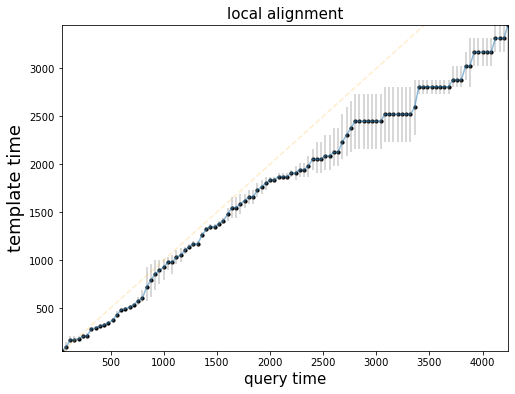

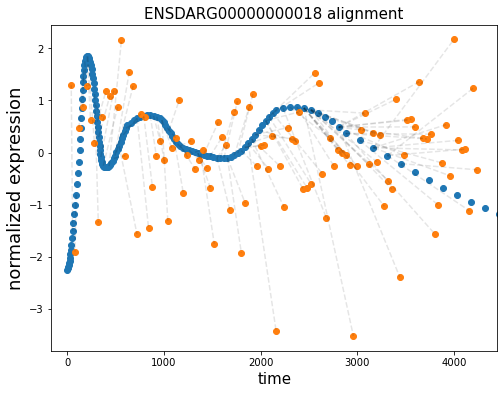

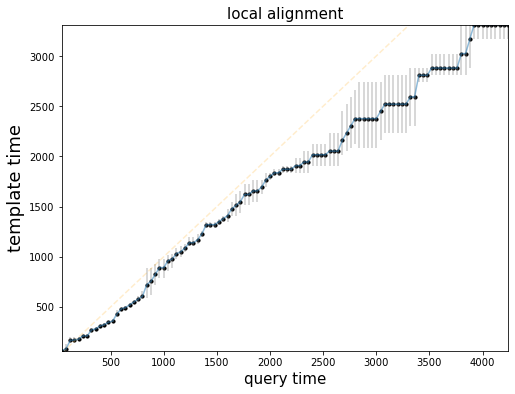

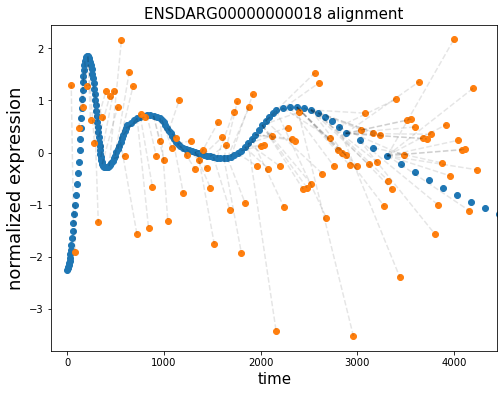

In [22]:
from tsa.alignment import time_series_alignment

template_gene_clusters = cluster_genes(template_tpms_inf, starting_genes, n_clusters=7)
paths = time_series_alignment(template_tpms_inf, query_tpms, template_gene_clusters, n_clust=50, tries=40, ncpu=40, cycles=2, showcase_gene=showcase_gene)

In [ ]:
save = False

if save:
    import codecs
    import nbformat as nbf
    from nbconvert.exporters import HTMLExporter
    from nbconvert.preprocessors import TagRemovePreprocessor
    from traitlets.config import Config

    # Setup config
    c = Config()

    # Configure tag removal - be sure to tag your cells to remove  using the
    # words remove_cell to remove cells. You can also modify the code to use
    # a different tag word
    c.TagRemovePreprocessor.remove_cell_tags = ("remove_cell",)
    c.TagRemovePreprocessor.remove_all_outputs_tags = ('remove_output',)
    c.TagRemovePreprocessor.remove_input_tags = ('remove_input',)
    c.TagRemovePreprocessor.enabled = True

    # Configure and run out exporter
    c.HTMLExporter.preprocessors = ["nbconvert.preprocessors.TagRemovePreprocessor"]

    exporter = HTMLExporter(config=c)
    exporter.register_preprocessor(TagRemovePreprocessor(config=c),True)

    notebook_name = 'clustering.ipynb'
    output_file_name = '???.html'

    # Configure and run our exporter - returns a tuple - first element with html,
    # second with notebook metadata
    output_notebook = nbf.read(notebook_name, as_version=4)

    # Write to output html file
    output, resources = exporter.from_notebook_node(output_notebook)
    codecs.open(output_file_name, 'w', encoding='utf-8').write(output)

### done

In [ ]:
# query_time = list2floats(query_tpms.columns)
# template_time = list2floats(template_tpms_inf.columns)

# scores = []
# spikes = []
# smoothness = []
# diffs = []
# for p in range(len(paths)):
#     path, stdev = paths[p]
    
#     score = abs(stdev).mean()
#     scores.append(score)
    
#     inferred_time = [template_time[i] for i in path]
    
#     spike = np.diff(inferred_time).max()
#     spikes.append(spike)
    
#     diff = [abs(inferred_time[i] - query_time[i]) for i in range(len(path))]
#     smoothness.append(np.mean(diff))
#     diffs.append(sum(diff))

# print("White vs. Levin")
# print(f"{n_genes} genes over {min_clust}-{max_clust-1} clusters")
# print(f"(with resampling in undersized clusters, {tries} tries)")
# print()
# print("Lower (darker) values are better")
# pd.DataFrame(
#     {
#         "n_clusters": list(range(min_clust, max_clust)), 
#         "stdev": scores, 
#         "largest jump": spikes, 
#         "|\u0394| from perfect": smoothness,
# #         "|\u0394| from perfect": diffs,
#     }
# ).astype(int).set_index("n_clusters").style.background_gradient(cmap='viridis')

In [ ]:
# print("median per alignment\n")

# paths3 = []
# for n_clusters in range(min_clust, max_clust):
#     template_gene_clusters = cluster_genes(template_tpms_inf, starting_genes, n_clusters=n_clusters)
#     path = avg_alignment(template_tpms_inf, query_tpms, template_gene_clusters, tries=tries, frac=None, n=n_genes, method="median", showcase_gene=showcase_gene, return_std=True)
#     paths3.append(path)

In [ ]:
# query_time = list2floats(query_tpms.columns)
# template_time = list2floats(template_tpms_inf.columns)

# scores = []
# spikes = []
# smoothness = []
# diffs = []
# for p in range(len(paths3)):
#     path, stdev = paths3[p]
    
#     score = abs(stdev).mean()
#     scores.append(score)
    
#     inferred_time = [template_time[i] for i in path]
    
#     spike = np.diff(inferred_time).max()
#     spikes.append(spike)
    
#     diff = [abs(inferred_time[i] - query_time[i]) for i in range(len(path))]
#     smoothness.append(np.mean(diff))
#     diffs.append(sum(diff))

# print("White vs. Levin")
# print(f"{n_genes} genes over {min_clust}-{max_clust-1} clusters")
# print(f"(with resampling in undersized clusters, {tries} tries)")
# print()
# print("Lower (darker) values are better")
# pd.DataFrame(
#     {
#         "n_clusters": list(range(min_clust, max_clust)), 
#         "stdev": scores, 
#         "largest jump": spikes, 
#         "|\u0394| from perfect": smoothness,
# #         "|\u0394| from perfect": diffs,
#     }
# ).astype(int).set_index("n_clusters").style.background_gradient(cmap='viridis')

### without replacement

In [ ]:
def avg_alignment2(template_tpms_inf, query_tpms, gene_cluster_df, tries=10, frac=0.2, n=None, metric='correlation', showcase_gene=None, plot=True, verbose=True, return_std=False):
    paths = np.zeros((tries, query_tpms.shape[1]))
    
    clusters = list(set(gene_cluster_df.cluster))
    n_clusters = len(clusters)
    c_avg = int(n/n_clusters)
    for try_n in range(tries):
        if verbose:
            print(f"{int(100*try_n/tries)}%", end="\r")

        if frac is not None and n is None:
        # get a fraction of genes per cluster
            genes = gene_cluster_df.groupby("cluster").sample(frac=frac).index.to_list()
        elif n is not None and frac is None:
#             genes = gene_cluster_df.groupby("cluster").sample(frac=frac, n=c_avg, replace=True).index.to_list()
            genes = []
            for cluster in clusters:
                c_genes = list(gene_cluster_df[gene_cluster_df.cluster == cluster].index)
                c_sample = min(len(c_genes), c_avg)
                genes.extend(random.sample(c_genes, c_sample))
        else:
            raise ValueError("use either `frac` or `n`")
            
        t = template_tpms_inf.loc[genes]
        q = query_tpms.loc[genes]

        cost_matrix = get_cost_matrix(t, q, metric)
        best_path, _ = best_alignment_graph(cost_matrix)

        paths[try_n] = best_path

    inference_time = list2floats(template_tpms_inf.columns)
    query_time = list2floats(query_tpms.columns)
    is_time_numeric = all_numeric(inference_time) and all_numeric(query_time)
    avg_path, std_path = _avg_alignments(paths, inference_time, is_time_numeric)
    
    if plot:
        n_genes = len(query_tpms)
        n_genes_used = len(q)
        print(f"\tAverage TSA of {tries} alignments with {n} genes \n"
              f"\t{n_clusters} clusters, ~{c_avg} genes per cluster")
#               f"\t{n_genes_used} of {n_genes} genes used")
#         if frac is not None:
#             print(f"Average TSA of {tries} alignments with {int(frac*100)}% of genes per cluster \n"
#                   f"({n_clusters} clusters, {n_genes_used} genes used of {n_genes} total genes)")
#         elif n is not None:
#             print(f"Average TSA of {tries} alignments with {n} genes (on average {c_avg} genes per cluster) \n"
#                   f"({n_clusters} clusters, {n_genes_used} genes used of {n_genes} total genes)")
        cm = pd.DataFrame(cost_matrix, index=q.columns, columns=t.columns)
        plot_alignment(cm, avg_path, std_path)
        
#         if is_time_numeric:
#             # gene mapping only makes sense if both query and template are in numeric time
#             plot_gene(query_tpms, template_tpms_inf, avg_path, showcase_gene, scale=True)

    if return_std:
        return avg_path, std_path
    return avg_path

In [ ]:
# print("random sampling without replacement\n")

# paths2 = []
# for n_clusters in range(min_clust, max_clust):
#     template_gene_clusters = cluster_genes(template_tpms_inf, starting_genes, n_clusters=n_clusters)
#     path = avg_alignment2(template_tpms_inf, query_tpms, template_gene_clusters, tries=tries, frac=None, n=n_genes, showcase_gene=showcase_gene, return_std=True)
#     paths2.append(path)

In [ ]:
# query_time = list2floats(query_tpms.columns)
# template_time = list2floats(template_tpms_inf.columns)

# scores = []
# spikes = []
# smoothness = []
# diffs = []
# for p in range(len(paths2)):
#     path, stdev = paths2[p]
    
#     score = abs(stdev).mean()
#     scores.append(score)
    
#     inferred_time = [template_time[i] for i in path]
    
#     spike = np.diff(inferred_time).max()
#     spikes.append(spike)
    
#     diff = [abs(inferred_time[i] - query_time[i]) for i in range(len(path))]
#     smoothness.append(np.mean(diff))
#     diffs.append(sum(diff))

# print("White vs. Levin")
# print(f"{n_genes} genes over {min_clust}-{max_clust-1} clusters")
# print(f"(without resampling in undersized clusters, {tries} tries)")
# print()
# print("Lower (darker) values are better")
# pd.DataFrame(
#     {
#         "n_clusters": list(range(min_clust, max_clust)), 
#         "stdev": scores, 
#         "largest jump": spikes, 
#         "|\u0394| from perfect": smoothness,
# #         "|\u0394| from perfect": diffs,
#     }
# ).astype(int).set_index("n_clusters").style.background_gradient(cmap='viridis')

### save notebook

In [ ]:
save = False

if save:
    import codecs
    import nbformat as nbf
    from nbconvert.exporters import HTMLExporter
    from nbconvert.preprocessors import TagRemovePreprocessor
    from traitlets.config import Config

    # Setup config
    c = Config()

    # Configure tag removal - be sure to tag your cells to remove  using the
    # words remove_cell to remove cells. You can also modify the code to use
    # a different tag word
    c.TagRemovePreprocessor.remove_cell_tags = ("remove_cell",)
    c.TagRemovePreprocessor.remove_all_outputs_tags = ('remove_output',)
    c.TagRemovePreprocessor.remove_input_tags = ('remove_input',)
    c.TagRemovePreprocessor.enabled = True

    # Configure and run out exporter
    c.HTMLExporter.preprocessors = ["nbconvert.preprocessors.TagRemovePreprocessor"]

    exporter = HTMLExporter(config=c)
    exporter.register_preprocessor(TagRemovePreprocessor(config=c),True)

    notebook_name = 'clustering.ipynb'
    output_file_name = 'mean_vs_median_clustered.html'

    # Configure and run our exporter - returns a tuple - first element with html,
    # second with notebook metadata
    output_notebook = nbf.read(notebook_name, as_version=4)

    # Write to output html file
    output, resources = exporter.from_notebook_node(output_notebook)
    codecs.open(output_file_name, 'w', encoding='utf-8').write(output)